In [3]:
%run ./src.ipynb

382, 48, 61, participants in Train, Validation, and Test sets
Processing fold 1...
Class weights:  {0: 1.0299494828000961, 1: 0.9717430776214253}
Epoch 1/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - AUC: 0.4922 - accuracy: 0.4930 - loss: 3.4562 - val_AUC: 0.5274 - val_accuracy: 0.5226 - val_loss: 2.8818 - learning_rate: 2.0000e-04
Epoch 2/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - AUC: 0.4983 - accuracy: 0.5011 - loss: 2.8695 - val_AUC: 0.5587 - val_accuracy: 0.5132 - val_loss: 2.6206 - learning_rate: 2.0000e-04
Epoch 3/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - AUC: 0.5115 - accuracy: 0.5107 - loss: 2.5883 - val_AUC: 0.5874 - val_accuracy: 0.5620 - val_loss: 2.3677 - learning_rate: 2.0000e-04
Epoch 4/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - AUC: 0.5363 - accuracy: 0.5318 - loss: 2.3204 - val_AUC: 0.6977 - val_accuracy: 0.6673 - val_loss: 2.1021 - learning_rate: 2.0000e-04
Epoch 5/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - AUC: 0.6371 - accuracy: 0.5920 - loss:

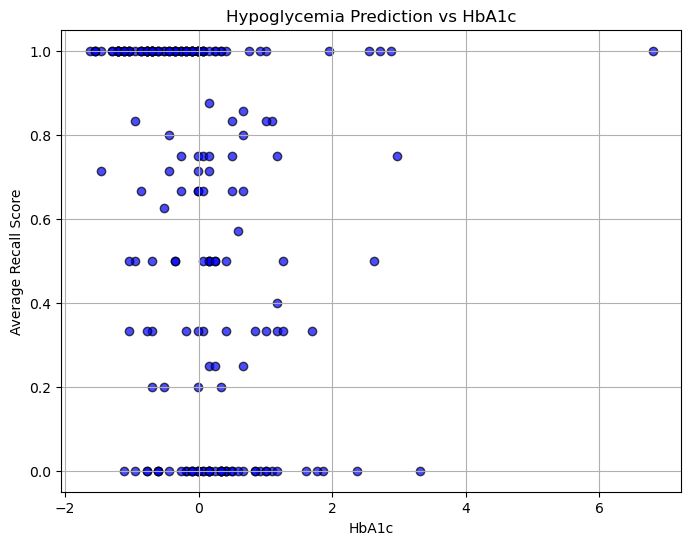

Plot saved at: /home/ma98/results/holdoutResultsFull/Day/loss_auc_accuracy_plot.png


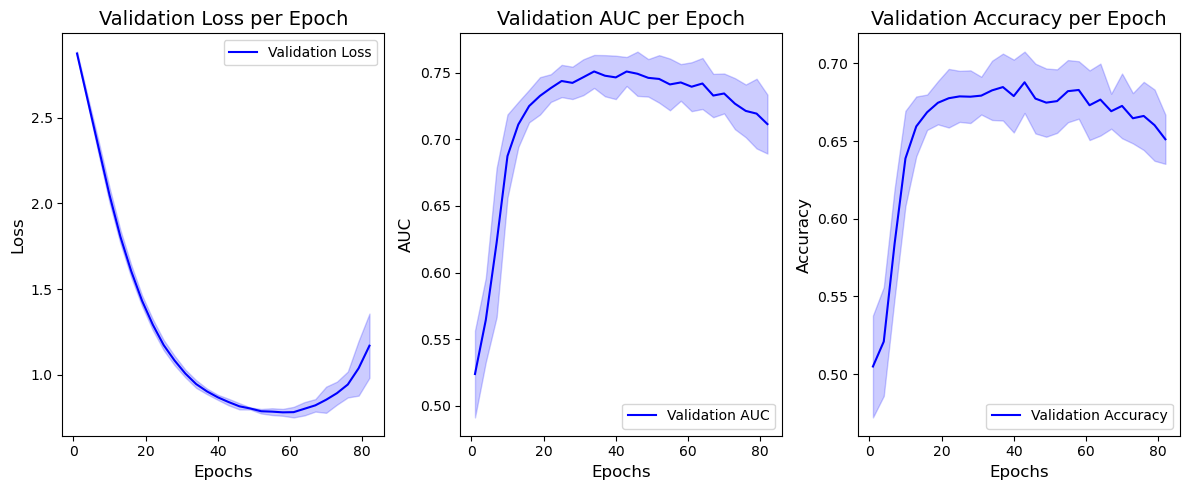

In [4]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Day"

configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_day",num_splits=10, num_epochs=60,batch_s=32, num_patience=20, monitored='val_loss',threshold=0.5)

# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Day/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Day/target_results.npy"
np.save(saved_results, target_results)



In [ ]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Day2"

configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_day",num_splits=10, num_epochs=60,batch_s=32, num_patience=17, monitored='val_loss',threshold=0.5)

gc.collect()

# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Day2/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Day2/target_results.npy"
np.save(saved_results, target_results)

